This notebook explains how to run diffusion inference code. The training code will also be provided but training in colab will not be possible since it will be difficult to share the dataset. The dataset is about 7 GBs and I am looking for some online storage to storing and sharing it. 

Here, we first generate the parameters by running the `diffusion_inference.py`. We then load the weights in our CNN model. However, we don't generate the fc parameters in this project, only the Conv2D parameters. Hence, we fine tune the cnn model for 5 epochs by freezing the conv layers and only training the fc layer. Finally, we take its predictions on small subset of the MNIST validation data and compute metrics.

In [1]:
import torch
import torch.nn as nn
from models.base_cnn import CnnBaseModel
from trainers.trainer_base_cnn import TrainerBaseCNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

### Run the diffusion inference code. 
It might require some time based on compute power.

In [2]:
!python3 diffusion_inference.py 

Starting reverse diffusion
99it [00:00, 171.51it/s]
Layer:1 done.
99it [00:00, 320.44it/s]
Layer:2 done.
99it [00:00, 330.98it/s]
Layer:3 done.
99it [00:00, 316.92it/s]
Layer:4 done.
Latent codes generated for all the layers. Now passing it to the decoder.
layer: 1: torch.Size([32, 32, 1, 3, 3])
layer: 2: torch.Size([32, 32, 32, 3, 3])
layer: 3: torch.Size([32, 64, 32, 3, 3])
layer: 4: torch.Size([32, 64, 64, 3, 3])
Weights saved in ./generated_weights


### Load the CNN Model

We load the cnn model using `CnnBaseModel`. 

In [3]:
cnn_model = CnnBaseModel()
for name, param in cnn_model.named_parameters():
    print(name, param.shape)

# load the conv2d weights. Note that the fc weigths are still random and need to be finetuned.    
weights = torch.load('./generated_weights/gen_weights_280.pth')
cnn_model.conv1[0].weight.data = weights[0].detach().clone()
cnn_model.conv2[0].weight.data = weights[1].detach().clone()
cnn_model.conv3[0].weight.data = weights[2].detach().clone()
cnn_model.conv4[0].weight.data = weights[3].detach().clone()

# put the model in eval mode
cnn_model.eval()
cnn_model = cnn_model.to(device)
# weights.keys()

CnnBaseModel created
conv1.0.weight torch.Size([32, 1, 3, 3])
conv2.0.weight torch.Size([32, 32, 3, 3])
conv3.0.weight torch.Size([64, 32, 3, 3])
conv4.0.weight torch.Size([64, 64, 3, 3])
fc.weight torch.Size([10, 64])
fc.bias torch.Size([10])


In [4]:
# print the layers
for name, param in cnn_model.named_parameters():
    print(name, param.shape)

conv1.0.weight torch.Size([32, 1, 3, 3])
conv2.0.weight torch.Size([32, 32, 3, 3])
conv3.0.weight torch.Size([64, 32, 3, 3])
conv4.0.weight torch.Size([64, 64, 3, 3])
fc.weight torch.Size([10, 64])
fc.bias torch.Size([10])


### Finetune few epochs to train the final fc layer

For finetuning, we use he `TrainerBaseCNN` class. 

In [5]:
def finetune_cnn(cnn_model):
    from torch.utils.data import DataLoader
    from dataloaders.mnist import train_dataset, val_dataset
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=7)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=7)
    
    trainer_base_cnn = TrainerBaseCNN(
        model=cnn_model,
        train_loader = train_loader,
        val_loader = val_loader,
        device = device,
        lr=1e-6,
        save_checkpoints=False,        
        epochs=5
    )
    
    trainer_base_cnn.train()
    
finetune_cnn(cnn_model)

100%|██████████| 79/79 [00:01<00:00, 77.80it/s] 


[Epoch:0] [Train:{'loss': 2.1728, 'metrics': {'acc': 0.2733}}] [Val:{'loss': 1.8991, 'metrics': {'acc': 0.4375}}]


100%|██████████| 79/79 [00:00<00:00, 79.85it/s] 


[Epoch:1] [Train:{'loss': 1.7549, 'metrics': {'acc': 0.5284}}] [Val:{'loss': 1.6204, 'metrics': {'acc': 0.5919}}]


100%|██████████| 79/79 [00:00<00:00, 83.98it/s] 


[Epoch:2] [Train:{'loss': 1.5412, 'metrics': {'acc': 0.6199}}] [Val:{'loss': 1.4493, 'metrics': {'acc': 0.6484}}]


100%|██████████| 79/79 [00:00<00:00, 85.21it/s] 


[Epoch:3] [Train:{'loss': 1.4039, 'metrics': {'acc': 0.6517}}] [Val:{'loss': 1.3333, 'metrics': {'acc': 0.6656}}]


100%|██████████| 79/79 [00:00<00:00, 82.45it/s] 

[Epoch:4] [Train:{'loss': 1.3067, 'metrics': {'acc': 0.6681}}] [Val:{'loss': 1.2477, 'metrics': {'acc': 0.6764}}]


### Load val data for MNIST

This is a small set of the validation data of MNIST. It is a batch of 128 images. 

In [6]:
val_data = torch.load('./mnist-val.pth')
X, y = val_data.values()
X = X.to(device)
y = y.to(device)

X.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

with torch.no_grad():
    y_pred = torch.argmax(cnn_model(X.to(device)), dim=-1)


print(classification_report(y.cpu().numpy(), y_pred.cpu().numpy()))


              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.82      0.90      0.86        10
           2       0.58      0.41      0.48        17
           3       0.56      0.71      0.63        14
           4       0.50      0.67      0.57         9
           5       0.20      0.14      0.17         7
           6       0.80      0.67      0.73        12
           7       0.72      0.81      0.76        16
           8       0.54      0.47      0.50        15
           9       0.62      0.62      0.62        13

    accuracy                           0.64       128
   macro avg       0.61      0.63      0.61       128
weighted avg       0.63      0.64      0.63       128



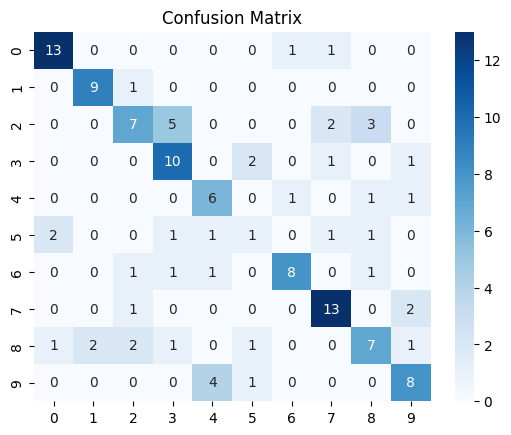

In [8]:
import seaborn as sea
import matplotlib.pyplot as plt
cm = confusion_matrix(y.cpu().numpy(), y_pred.cpu().numpy())

sea.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

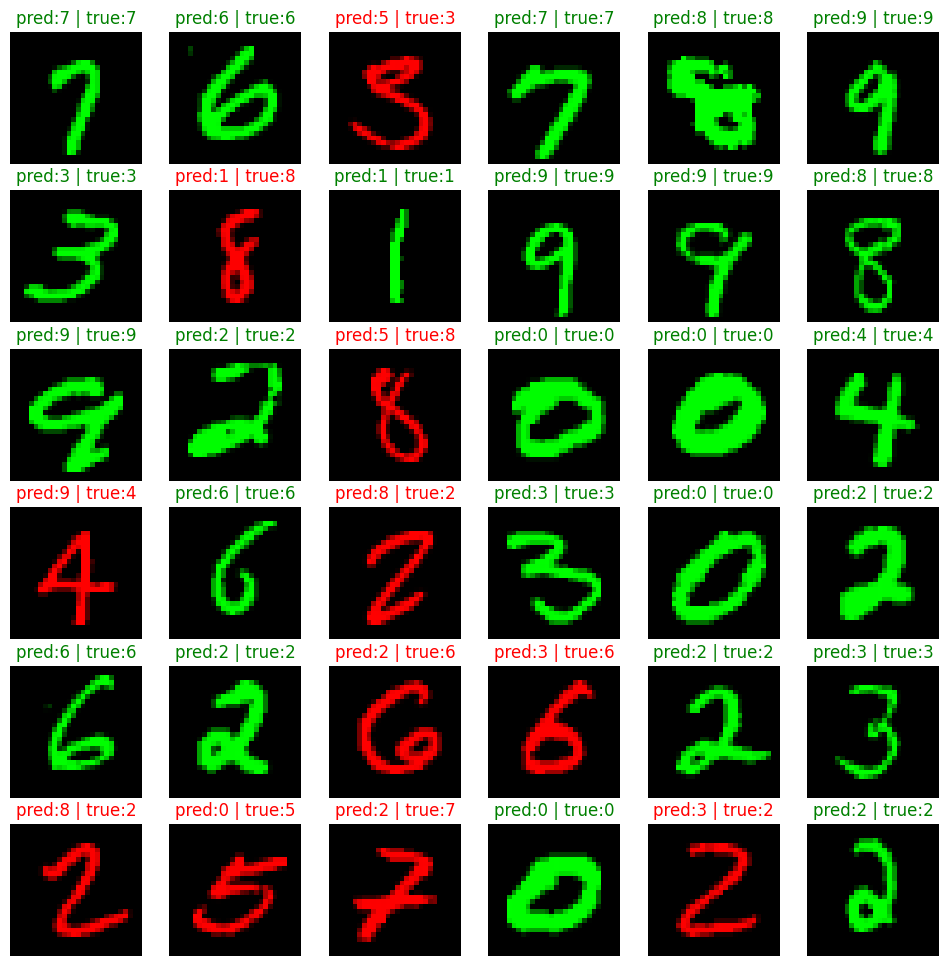

In [17]:
def plot_grid(X, y, y_pred, n=36):
    plt.figure(figsize=(12, 12))
    for i in range(36):
        plt.subplot(6, 6, i + 1)
        i = i + 36
        if y_pred[i] == y[i]:
            img = torch.stack([torch.zeros_like(X[i]), X[i], torch.zeros_like(X[i])], dim=1)
        else:
            img = torch.stack([X[i], torch.zeros_like(X[i]), torch.zeros_like(X[i])], dim=1)
        
        plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
        plt.title(f'pred:{y_pred[i]} | true:{y[i]}', color='green' if y_pred[i] == y[i] else 'red')
        plt.axis('off')
        
    plt.show()
    
plot_grid(X.cpu(), y.cpu(), y_pred.cpu())